# Importing Libraries

In [31]:
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install -U sentence-transformers
!pip install hyperopt
!pip install optuna

import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV



# SBERT

# Dataset Loading

In [32]:
df= pd.read_csv("D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\BERT_v7.csv")

In [33]:
s_bert_all_embeddings = np.load('D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\SBERT_v7_embeddings.npy',allow_pickle=True)

In [34]:
df['embeddings'] = [embedding for embedding in s_bert_all_embeddings]

In [35]:
df.shape

(199709, 3)

In [32]:
df['url_length'] = df['url'].apply(len)

In [33]:
df = df[df['url_length'] <= 512].drop(columns=['url_length'])

In [34]:
df.shape

(199709, 3)

# Data Visulaization

In [36]:
type_counts = df['type'].value_counts()
type_counts

type
1    99998
0    99711
Name: count, dtype: int64

In [37]:
# df=df.drop(columns=['url_length_range'],axis=1)

In [38]:
df.tail()

,url,type,embeddings
199704,en.wikipedia.org/wiki/USS_Capricornus_(AKA-57),1,"[-0.020177916, -0.053662118, -0.002932505, -0...."
199705,muscleinjuries.com/fs56qjqt,0,"[0.0233986, -0.032973006, -0.023431282, -0.029..."
199706,webmail.mhcable.com/secure/www.paypal.com/webs...,0,"[0.031648938, 0.000941706, -0.00083338935, 0.0..."
199707,publicrecords.com/people-search-records/meliss...,1,"[0.020182298, 0.004621455, 0.004842566, 0.0006..."
199708,freeserials.ws/sn/64850.html,0,"[0.05703807, 0.0047999667, 0.01277246, 0.01219..."


# Dataset Preprocessing

In [39]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['url', 'embeddings']

In [40]:
l_encoder = LabelEncoder()

encoded_data = l_encoder.fit_transform(df['type'])

df['type'] = encoded_data

In [41]:
df.tail()

,url,type,embeddings
199704,en.wikipedia.org/wiki/USS_Capricornus_(AKA-57),1,"[-0.020177916, -0.053662118, -0.002932505, -0...."
199705,muscleinjuries.com/fs56qjqt,0,"[0.0233986, -0.032973006, -0.023431282, -0.029..."
199706,webmail.mhcable.com/secure/www.paypal.com/webs...,0,"[0.031648938, 0.000941706, -0.00083338935, 0.0..."
199707,publicrecords.com/people-search-records/meliss...,1,"[0.020182298, 0.004621455, 0.004842566, 0.0006..."
199708,freeserials.ws/sn/64850.html,0,"[0.05703807, 0.0047999667, 0.01277246, 0.01219..."


In [24]:
df = df.drop_duplicates(subset=['url'])

In [41]:
df['url'] = df['url'].str.strip("'")

In [42]:
df = df[~df['url'].str.contains('bitly|tinyURL', case=False, na=False)]

In [43]:
df = df.dropna(how='all')
df.shape

(199709, 3)

# Feature Extraction

In [43]:
import urllib.parse
from urllib.parse import unquote
import re
import math


def extract_URL_features(url):

  try:

    features = {}

    url=unquote(url) # convert encoding to text in URL

    parsed_url = urllib.parse.urlparse(url)

    if(("//") not in url):

      url=url.strip("//")

      url_path="".join([part for part in url.split("/")[1:]])

      features['url_length']=len(url)

      features['domain_length']=len(url.split("/")[0])

      features['path_length'] = (sum(len(part) for part in url.split("/")[1:]))

      domain_parts=url.split("/")[0].split('.')

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0

      features['path_depth'] = len(url.split("/"))

      features['has_file_extension'] = 1 if re.search(r'\.\w+$', url_path) else 0

      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      # Digit to letter ratio
      digit_count = sum(1 for char in url_path if char.isdigit())
      letter_count = sum(1 for char in url_path if char.isalpha())
      features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0


      suspicious_keywords = ["login", "update", "verify", "secure", "account","password","reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in url_path.lower() for word in suspicious_keywords)


    else:

      domain_parts = parsed_url.netloc.split('.')
      
      features['url_length']=len(url)
      # print("url : ",url)

      features['domain_length']=len(parsed_url.netloc)
      # print("domain : ",parsed_url.netloc)

      features['path_length'] = len(parsed_url.path)
      # print("path : ",parsed_url.path)

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0
      # print("domain :",domain_parts)

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0
      features['path_depth'] = parsed_url.path.count('/')
      features['has_file_extension'] = 1 if re.search(r'\.\w+$', parsed_url.path) else 0
      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      digit_count = sum(1 for char in parsed_url.path if char.isdigit())
      letter_count = sum(1 for char in parsed_url.path if char.isalpha())
      features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0

      suspicious_keywords = ["login", "update", "verify", "secure", "account","password", "reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in parsed_url.path.lower() for word in suspicious_keywords)

  except Exception as e:
    print("Exception in URL :",url)
    return None  # Return None or a default value for failed cases

  return features
    
extract_URL_features("apple-checker.org/")


{'url_length': 17,
 'domain_length': 17,
 'path_length': 0,
 'num_subdomains': 0,
 'subdomain_length': 0,
 'path_depth': 1,
 'has_file_extension': 0,
 'equal_count': 0,
 'redirects': 0,
 'query_param_count': 0,
 'dot_char_count': 1,
 'hyphen_char_count': 1,
 'tld_domain_length': 3,
 'space_char_count': 0,
 'www_count': 0,
 'http_count': 0,
 'digit_letter_ratio': 0,
 'suspicious_path_keywords': 0}

In [44]:
fs=df['url'].map(extract_URL_features)

In [45]:
fs=fs.to_list()

In [46]:
url_features_frame = pd.json_normalize(fs)

In [47]:
df = df.reset_index(drop=True)
url_features_frame = url_features_frame.reset_index(drop=True)
df = pd.concat([df, url_features_frame], axis=1)
print(df.shape)

(199709, 21)


In [48]:
# df = pd.concat([df, url_features_frame], axis=1)
# df.shape

In [49]:
df.tail()

,url,type,embeddings,url_length,domain_length,path_length,num_subdomains,subdomain_length,path_depth,has_file_extension,...,redirects,query_param_count,dot_char_count,hyphen_char_count,tld_domain_length,space_char_count,www_count,http_count,digit_letter_ratio,suspicious_path_keywords
199704,en.wikipedia.org/wiki/USS_Capricornus_(AKA-57),1,"[-0.020177916, -0.053662118, -0.002932505, -0....",46,16,28,1,2,3,0,...,0,0,2,1,3,0,0,0,0.095238,0
199705,muscleinjuries.com/fs56qjqt,0,"[0.0233986, -0.032973006, -0.023431282, -0.029...",27,18,8,0,0,2,0,...,0,0,1,0,3,0,0,0,0.333333,0
199706,webmail.mhcable.com/secure/www.paypal.com/webs...,0,"[0.031648938, 0.000941706, -0.00083338935, 0.0...",158,19,136,1,7,4,0,...,0,1,5,1,3,0,1,0,0.242424,2
199707,publicrecords.com/people-search-records/meliss...,1,"[0.020182298, 0.004621455, 0.004842566, 0.0006...",55,17,36,0,0,3,0,...,0,0,1,3,3,0,0,0,0.000000,0
199708,freeserials.ws/sn/64850.html,0,"[0.05703807, 0.0047999667, 0.01277246, 0.01219...",28,14,12,0,0,3,1,...,0,0,2,0,2,0,0,0,0.833333,0


# Feature Visualization

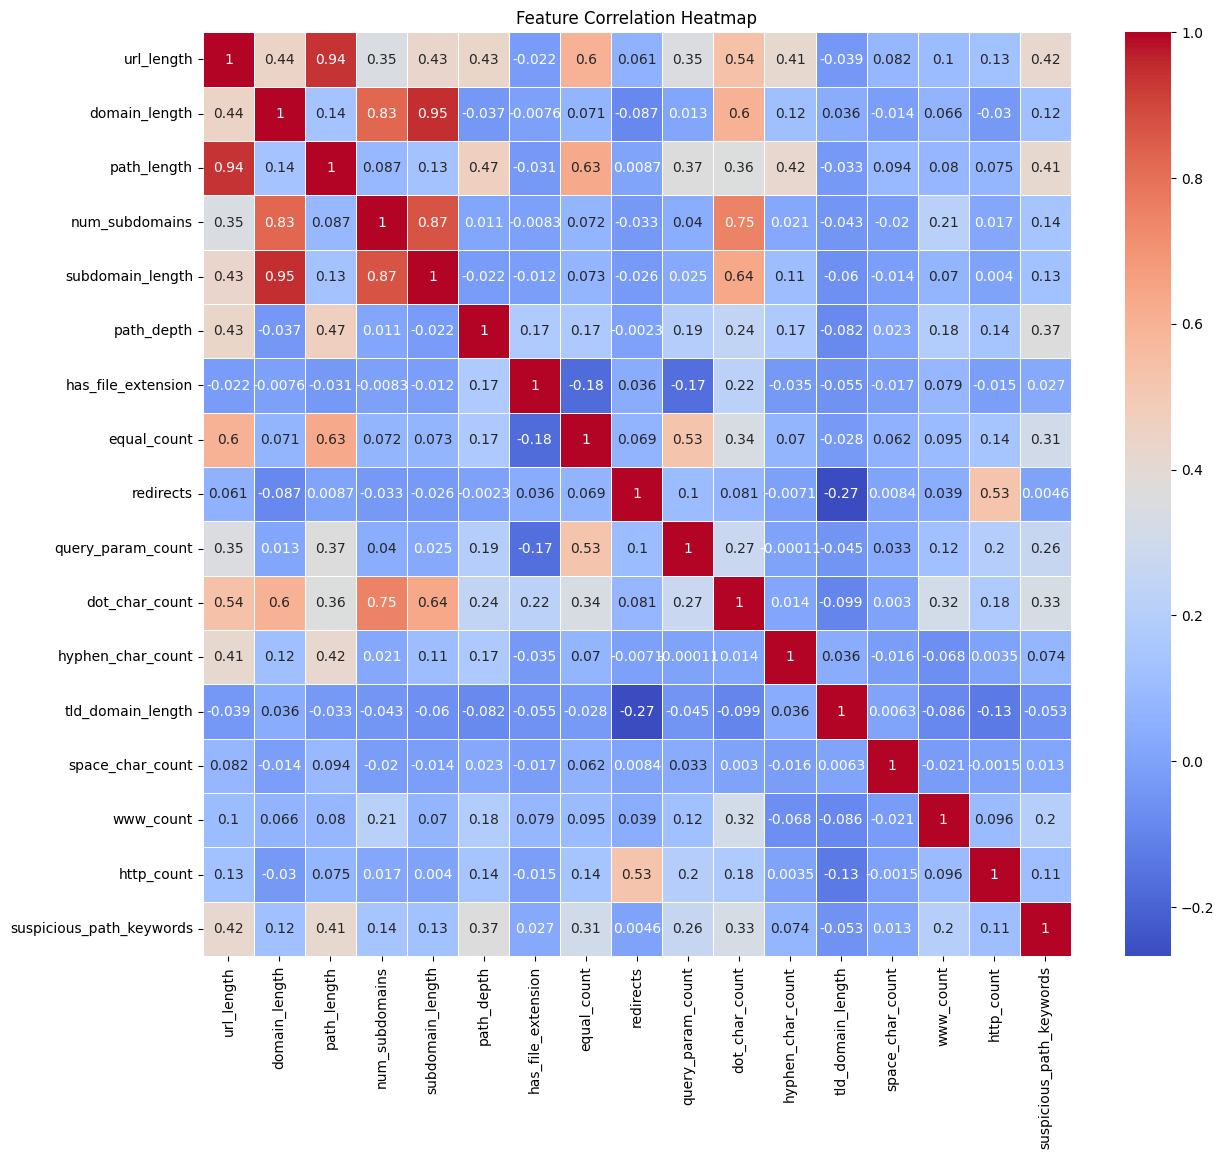

In [28]:
import matplotlib.pyplot as plt

df_visual = df.drop(columns=['url', 'type','embeddings'])

plt.figure(figsize=(14, 12))
sns.heatmap(df_visual.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [50]:
import pandas as pd

# Step 2: Define the bins (ranges) for URL lengths
bins = [0,10, 30, 50, 100, 200, 300, 400, 500, 1000, float('inf')]
labels = ['0-10','10-30','30-50', '51-100', '101-200', '201-300', '301-400', '401-500', '501-1000', '1001+']

# Step 3: Categorize the URLs into the defined bins
df['url_length_range'] = pd.cut(df['url_length'], bins=bins, labels=labels)

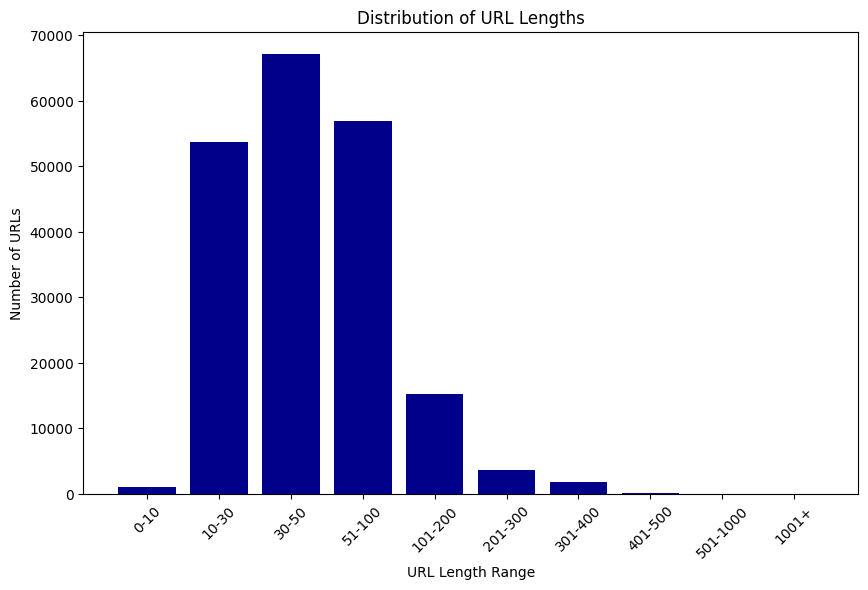

In [51]:
import matplotlib.pyplot as plt

# Step 4: Count the number of URLs in each range
url_length_distribution = df['url_length_range'].value_counts().sort_index()

# Step 5: Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(url_length_distribution.index, url_length_distribution.values, color='darkblue')
plt.title('Distribution of URL Lengths')
plt.xlabel('URL Length Range')
plt.ylabel('Number of URLs')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [53]:
df=df.drop(columns=['url_length_range'])

# Dataset Filtering

<Axes: xlabel='type', ylabel='count'>

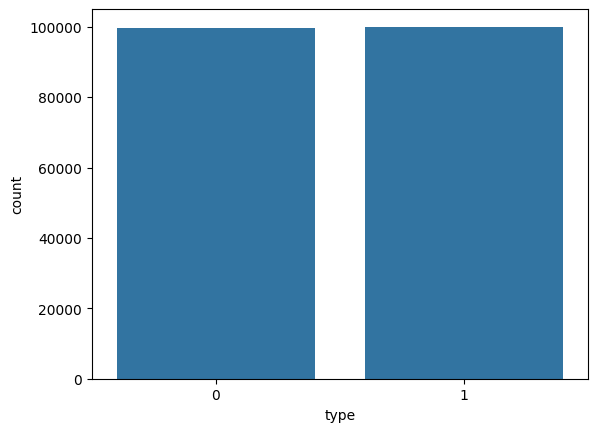

In [54]:
sns.countplot(x='type',data=df)

In [12]:
def sample_data(df, phishing_size, benign_size):
    phishing_samples = df[df['type'] == 1].sample(n=phishing_size, random_state=42)
    benign_samples = df[df['type'] == 0].sample(n=benign_size, random_state=42)
    return pd.concat([phishing_samples, benign_samples]).sample(frac=1).reset_index(drop=True)

#Sample 50k phishing and 50k benign URLs
sampled_df_30k = sample_data(df, phishing_size=15000, benign_size=15000)

#Sample 50k phishing and 50k benign URLs
sampled_df_50k = sample_data(df, phishing_size=25000, benign_size=25000)

#Sample 50k phishing and 50k benign URLs
sampled_df_100k = sample_data(df, phishing_size=50000, benign_size=50000)

#50k phishing and 50k benign URLs
sampled_df_200k = sample_data(df, phishing_size=100000, benign_size=100000)

# #Sample 150k phishing and 150k benign URLs
# sampled_df_300k = sample_data(df, phishing_size=150000, benign_size=150000)

# #Sample 150k phishing and 150k benign URLs
# sampled_df_400k = sample_data(df, phishing_size=200000, benign_size=200000)

# #Sample 150k phishing and 150k benign URLs
# sampled_df_450k = sample_data(df, phishing_size=225000, benign_size=225000)

# #Sample 150k phishing and 150k benign URLs
# sampled_df_600k = sample_data(df, phishing_size=300000, benign_size=300000)

# #Sample 150k phishing and 150k benign URLs
# sampled_df_700k = sample_data(df, phishing_size=350000, benign_size=350000)


In [50]:
from sklearn.preprocessing import StandardScaler

# Select numeric features excluding 'type'
features = df.drop(columns=['type','embeddings','url'])

# Normalize numeric features if necessary
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert embeddings to a 2D array
embeddings_array = np.stack(df['embeddings'].values)

# Concatenate features and embeddings
X = np.hstack((features_scaled, embeddings_array))
y = df['type'].values

# Train Test Split

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

In [121]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

# Logistic Regression

In [24]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\kanis\AppData\Local\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [25]:
lr_pred = lr.predict(X_test)
print("LR Classifier Accuracy:",metrics.accuracy_score(y_test, lr_pred))
print("LR Classifier Recall:",metrics.recall_score(y_test, lr_pred))
print("LR Classifier Precision:",metrics.precision_score(y_test, lr_pred))

LR Classifier Accuracy: 0.9288718642030945
LR Classifier Recall: 0.93595
LR Classifier Precision: 0.9230731298387495


In [34]:
accuracy_score(y_test, lr_pred)

0.9293225176505934

# XG Boost Classification Model

In [139]:
clf_xgb = XGBClassifier(objective="binary:logistic")

In [140]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [141]:
XGB_pred = clf_xgb.predict(X_test)
print("XG Boost Classifier Accuracy:",metrics.accuracy_score(y_test, XGB_pred))
print("XG Boost Classifier Recall:",metrics.recall_score(y_test, XGB_pred))
print("XG Boost Classifier Precision:",metrics.precision_score(y_test, XGB_pred))

XG Boost Classifier Accuracy: 0.95243102498623
XG Boost Classifier Recall: 0.9543
XG Boost Classifier Precision: 0.95087684336389


# XG Boost Hyperparamter Classifier

In [59]:
clf_xgb = XGBClassifier(
    n_estimators=600,
    max_depth=7,
    gamma=0.01,
    reg_alpha=80,
    min_child_weight=6,
    colsample_bytree=0.5
)

In [60]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [61]:
XGB_pred = clf_xgb.predict(X_test)
print("XG Boost Classifier Accuracy:",accuracy_score(y_test, XGB_pred))
print("XG Boost Classifier Recall:",recall_score(y_test, XGB_pred))
print("XG Boost Classifier Precision:",precision_score(y_test, XGB_pred))

XG Boost Classifier Accuracy: 0.9497771769065144
XG Boost Classifier Recall: 0.95295
XG Boost Classifier Precision: 0.9470781156827669


# XG Boost Hyperparamter Classification Report

In [710]:
XGB_pred = clf_xgb.predict(X_test)
print("XG Boost Classifier Accuracy:",accuracy_score(y_test, XGB_pred))
print("XG Boost Classifier Recall:",recall_score(y_test, XGB_pred))
print("XG Boost Classifier Precision:",precision_score(y_test, XGB_pred))

print("\n XG Boost Classification Report: \n")

report = classification_report(y_test, XGB_pred)
print(report)

AttributeError: 'dict' object has no attribute 'accuracy_score'

In [634]:
# Make predictions
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)

# Calculate accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9915067733889767
Test Accuracy: 0.9844025091615697


In [635]:
fpr,tpr, thres=roc_curve(y_test, XGB_pred)

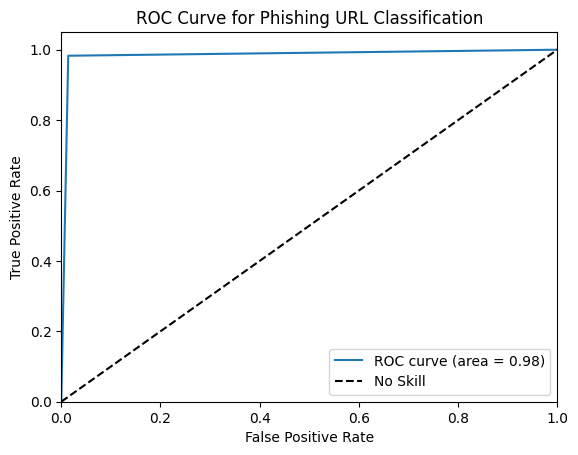

In [636]:
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')
plt.legend()
plt.show()

# LightGBM Classification Model

In [62]:
clf_lgb=LGBMClassifier(learning_rate= 0.09092019196120222,
num_leaves = 200,
max_depth = 23,
min_child_samples = 47,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)

# LightGBM Hyperparmeter Grid Search

In [ ]:
def objective(trial):
  # Determine the hyperperatemers and their value ranges
  learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
  num_leaves = trial.suggest_int("num_leaves", 2, 256)
  max_depth = trial.suggest_int("max_depth", -1, 50)
  min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
  subsample = trial.suggest_float("subsample", 0.5, 1.0)
  colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
  n_estimators = trial.suggest_int("n_estimators", 100, 1000)
  
  # Create and train the model
  model = LGBMClassifier(
  learning_rate=learning_rate,
  num_leaves=num_leaves,
  max_depth=max_depth,
  min_child_samples=min_child_samples,
  subsample=subsample,
  colsample_bytree=colsample_bytree,
  n_estimators=n_estimators,
  random_state=42
  )
  model.fit(X_train, y_train)
  
  # Evaluate model and return the metric
  clf_lgbm_pred = model.predict(X_test)
  accuracy = metrics.accuracy_score(y_test, clf_lgbm_pred)
  return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

# LightGBM Training & Testing 

In [63]:
clf_lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 79998, number of negative: 79769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.091775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197241
[LightGBM] [Info] Number of data points in the train set: 159767, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500717 -> initscore=0.002867
[LightGBM] [Info] Start training from score 0.002867


LGBMClassifier(colsample_bytree=0.8200479625575507,
               learning_rate=0.09092019196120223, max_depth=23,
               min_child_samples=47, n_estimators=1000, num_leaves=200,
               subsample=0.9808438292511631)

In [64]:
clf_lgb_predict = clf_lgb.predict(X_test)
print("LightGBM Classifier Accuracy:",accuracy_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Recall:",recall_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Precision:",precision_score(y_test, clf_lgb_predict))

LightGBM Classifier Accuracy: 0.9658755195032798
LightGBM Classifier Recall: 0.9695
LightGBM Classifier Precision: 0.9626172864022241


In [109]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, clf_lgb_predict)
tn, fp, fn, tp = cm.ravel()

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

False Positive Rate: 0.0100


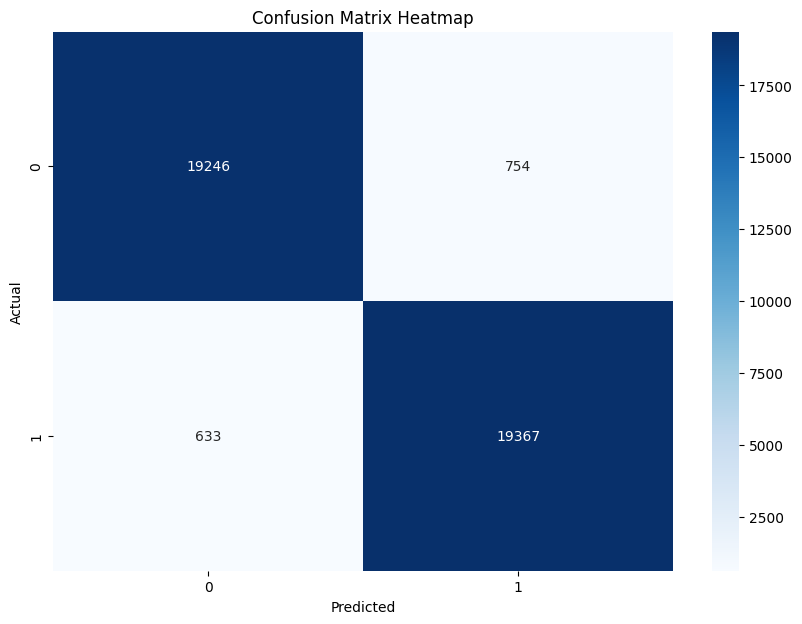

In [120]:
# Plot confusion matrix heatmap

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# LightGBM Classification Report

In [121]:
print("LightGBM Classifier Accuracy:",metrics.accuracy_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Recall:",metrics.recall_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Precision:",metrics.precision_score(y_test, clf_lgb_predict))

report = classification_report(y_test, clf_lgb_predict)

print(report)

LightGBM Classifier Accuracy: 0.965325
LightGBM Classifier Recall: 0.96835
LightGBM Classifier Precision: 0.9625267133840266
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     20000
           1       0.96      0.97      0.97     20000

    accuracy                           0.97     40000
   macro avg       0.97      0.97      0.97     40000
weighted avg       0.97      0.97      0.97     40000



# LightGBM Train & Testing Accuracy

In [122]:
# Make predictions
y_train_lgb_pred = clf_lgb.predict(X_train)
y_test_lgb_pred = clf_lgb.predict(X_test)

# Calculate accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_lgb_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_lgb_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.965325


# Catboost Classification Model

In [167]:
clf_cat = CatBoostClassifier(iterations=1000)

clf_cat.fit(X_train, y_train,verbose=True)

Learning rate set to 0.089913
0:	learn: 0.6179367	total: 804ms	remaining: 13m 22s
1:	learn: 0.5670401	total: 1.61s	remaining: 13m 22s
2:	learn: 0.5268815	total: 2.42s	remaining: 13m 24s
3:	learn: 0.4859317	total: 3.26s	remaining: 13m 31s
4:	learn: 0.4571331	total: 4.04s	remaining: 13m 23s
5:	learn: 0.4329230	total: 4.83s	remaining: 13m 19s
6:	learn: 0.4130206	total: 5.66s	remaining: 13m 22s
7:	learn: 0.3957905	total: 6.5s	remaining: 13m 26s
8:	learn: 0.3797525	total: 7.27s	remaining: 13m 20s
9:	learn: 0.3677904	total: 8.12s	remaining: 13m 24s
10:	learn: 0.3554962	total: 8.92s	remaining: 13m 21s
11:	learn: 0.3457001	total: 9.69s	remaining: 13m 18s
12:	learn: 0.3362614	total: 10.4s	remaining: 13m 9s
13:	learn: 0.3282937	total: 11.2s	remaining: 13m 6s
14:	learn: 0.3214114	total: 12s	remaining: 13m 5s
15:	learn: 0.3152666	total: 12.8s	remaining: 13m 6s
16:	learn: 0.3086668	total: 13.5s	remaining: 12m 59s
17:	learn: 0.3032372	total: 14.2s	remaining: 12m 53s
18:	learn: 0.2974543	total: 14.9s

In [ ]:
def objective(trial):
  # Determine the hyperperatemers and their value ranges
  iterations = trial.suggest_categorical("iterations", [1000, 2000, 3000])
  
  # Create and train the model
  model = CatBoostClassifier(
  iterations=iterations,
  random_state=42
  )
  model.fit(X_train, y_train)
  
  # Evaluate model and return the metric
  clf_catboost_pred = model.predict(X_test)
  accuracy = metrics.accuracy_score(y_test, clf_catboost_pred)
  return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

In [168]:
clf_cat_pred = clf_cat.predict(X_test)
print("CatBoost Classifier Accuracy:",accuracy_score(y_test, clf_cat_pred))
print("CatBoost Classifier Recall:",recall_score(y_test, clf_cat_pred))
print("CatBoost Classifier Precision:",precision_score(y_test, clf_cat_pred))

CatBoost Classifier Accuracy: 0.9584147013169095
CatBoost Classifier Recall: 0.96075
CatBoost Classifier Precision: 0.9563983873376138


In [590]:
report = classification_report(y_test, clf_cat_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     38526
           1       0.99      0.98      0.99     40153

    accuracy                           0.99     78679
   macro avg       0.99      0.99      0.99     78679
weighted avg       0.99      0.99      0.99     78679



In [591]:
# Make predictions
y_train_cat_pred = clf_cat.predict(X_train)
y_test_cat_pred = clf_cat.predict(X_test)

# Calculate accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_cat_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_cat_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9944838981300542
Test Accuracy: 0.985256548761423


# Classification Models Performance Comparision

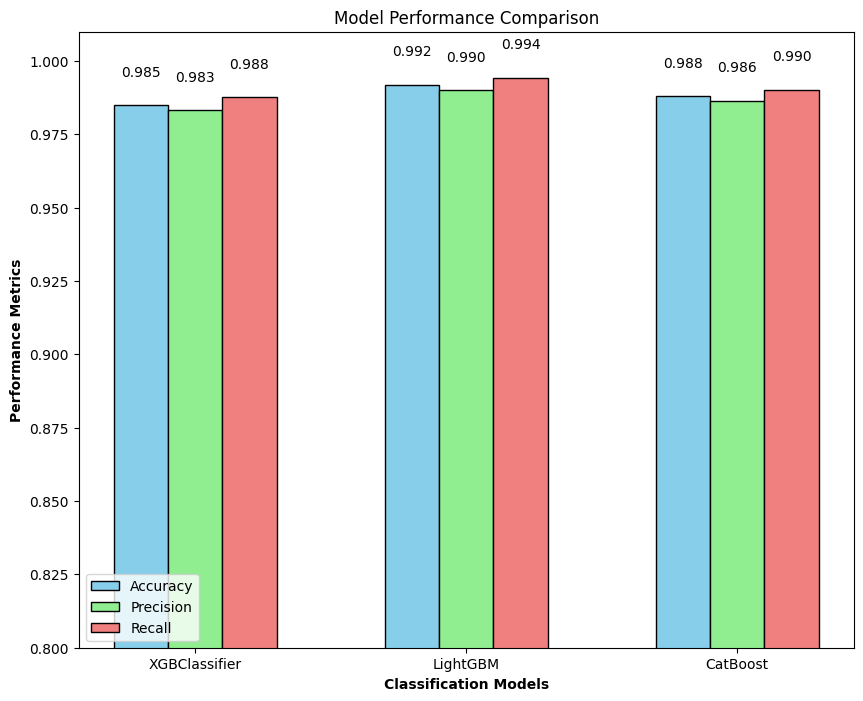

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Example values for each metric (replace these with your actual values)
metrics = {
    'XGBClassifier': {'accuracy': accuracy_score(y_test, XGB_pred), 'precision': recall_score(y_test, XGB_pred), 'recall': precision_score(y_test, XGB_pred)},
    'LightGBM': {'accuracy': accuracy_score(y_test, clf_lgb_predict), 'precision': recall_score(y_test, clf_lgb_predict), 'recall': precision_score(y_test, clf_lgb_predict)},
    'CatBoost': {'accuracy': accuracy_score(y_test, clf_cat_pred), 'precision': recall_score(y_test, clf_cat_pred), 'recall': precision_score(y_test, clf_cat_pred)}
}

# Models and metric categories
models = list(metrics.keys())
categories = ['accuracy', 'precision', 'recall']

# Extracting the values
accuracy_values = [metrics[model]['accuracy'] for model in models]
precision_values = [metrics[model]['precision'] for model in models]
recall_values = [metrics[model]['recall'] for model in models]

# Define bar width and positions
bar_width = 0.2
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.figure(figsize=(10, 8))
plt.bar(r1, accuracy_values, color='skyblue', width=bar_width, edgecolor='black', label='Accuracy')
plt.bar(r2, precision_values, color='lightgreen', width=bar_width, edgecolor='black', label='Precision')
plt.bar(r3, recall_values, color='lightcoral', width=bar_width, edgecolor='black', label='Recall')

# Add labels and title
plt.xlabel('Classification Models', fontweight='bold')
plt.ylabel('Performance Metrics', fontweight='bold')
plt.title('Model Performance Comparison')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylim(0.8, 1.01)  # Set y-axis from 0 to 1

# Add legend
plt.legend()

# Add values on top of bars
for i in range(len(r1)):
    plt.text(r1[i], accuracy_values[i] + 0.01, f'{accuracy_values[i]:.3f}', ha='center')
    plt.text(r2[i], precision_values[i] + 0.01, f'{precision_values[i]:.3f}', ha='center')
    plt.text(r3[i], recall_values[i] + 0.01, f'{recall_values[i]:.3f}', ha='center')

# Show plot
plt.show()

# Stacking Model

## Zero Level Stacking

In [52]:
estimators = []

estimators.append(('XGB', XGBClassifier(objective="binary:logistic",random_state=13,n_estimators=1000,
    max_depth=15,
    gamma=6,
    reg_alpha=80,
    min_child_weight=5,
    colsample_bytree=0.5)))
estimators.append(('CatBoost',  CatBoostClassifier(iterations=1000)))
estimators.append(('LightGBM', LGBMClassifier(learning_rate= 0.05092019196120222,
num_leaves = 200,
max_depth = 22,
min_child_samples = 50,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)))

## First Level Stacking

In [53]:
LR_clf = LogisticRegression()

## Stacking Classifier

In [54]:
SC = StackingClassifier(estimators=estimators,final_estimator=LR_clf)

In [55]:
len(X_train)

159767

In [56]:
SC.fit(X_train, y_train)

Learning rate set to 0.089913
0:	learn: 0.6344818	total: 445ms	remaining: 7m 24s
1:	learn: 0.5844306	total: 623ms	remaining: 5m 10s
2:	learn: 0.5471260	total: 892ms	remaining: 4m 56s
3:	learn: 0.5162907	total: 1.29s	remaining: 5m 22s
4:	learn: 0.4899259	total: 1.75s	remaining: 5m 47s
5:	learn: 0.4666191	total: 2.13s	remaining: 5m 52s
6:	learn: 0.4480178	total: 2.54s	remaining: 6m
7:	learn: 0.4315390	total: 3.02s	remaining: 6m 14s
8:	learn: 0.4166659	total: 3.4s	remaining: 6m 14s
9:	learn: 0.4008322	total: 3.75s	remaining: 6m 11s
10:	learn: 0.3904889	total: 4.17s	remaining: 6m 14s
11:	learn: 0.3814914	total: 4.56s	remaining: 6m 15s
12:	learn: 0.3723860	total: 4.92s	remaining: 6m 13s
13:	learn: 0.3647812	total: 5.31s	remaining: 6m 13s
14:	learn: 0.3565763	total: 5.64s	remaining: 6m 10s
15:	learn: 0.3491488	total: 5.96s	remaining: 6m 6s
16:	learn: 0.3436119	total: 6.35s	remaining: 6m 7s
17:	learn: 0.3367156	total: 6.65s	remaining: 6m 2s
18:	learn: 0.3295207	total: 7.01s	remaining: 6m 2s
1

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=6,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate...
                                              num_parallel_tree=None,
                                              random_state=13, ...)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x0000027D9EA84310>),
                               ('LightGBM',
                                LGBMClassifier(colsample_bytree=0.8200479625575507,
                                               learning_rate=0.05092019196120222,
                                               max_depth=22,
                                               min_child_samples=50,
                                               n_estimators=1000,
                                               num_leaves=200,
                                               subsample=0.9808438292511631))],
                   final_estimator=LogisticRegression())

## Stacking Classifier Performance Metrics

In [58]:
SC_pred = SC.predict(X_test)
print("Stacking Classifier Accuracy:",metrics.accuracy_score(y_test, SC_pred))
print("Stacking Classifier Recall:",metrics.recall_score(y_test, SC_pred))
print("Stacking  Classifier Precision:",metrics.precision_score(y_test, SC_pred))

Stacking Classifier Accuracy: 0.9640979420159231
Stacking Classifier Recall: 0.96675
Stacking  Classifier Precision: 0.9617489056904098


In [59]:
report = classification_report(y_test, SC_pred)

print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     19942
           1       0.96      0.97      0.96     20000

    accuracy                           0.96     39942
   macro avg       0.96      0.96      0.96     39942
weighted avg       0.96      0.96      0.96     39942



In [60]:
# Make predictions
y_train_lgb_pred = SC.predict(X_train)
y_test_lgb_pred = SC.predict(X_test)

# Calculate accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_lgb_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_lgb_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9992489062196824
Test Accuracy: 0.9640979420159231


In [61]:
fpr,tpr, thres=roc_curve(y_test, SC_pred)

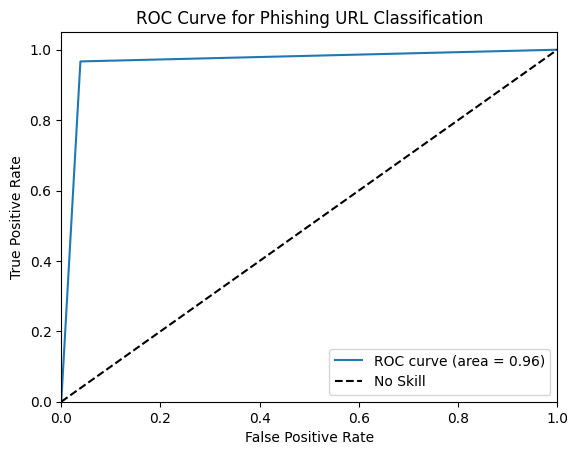

In [62]:
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, SC_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

False Positive Rate: 0.0386


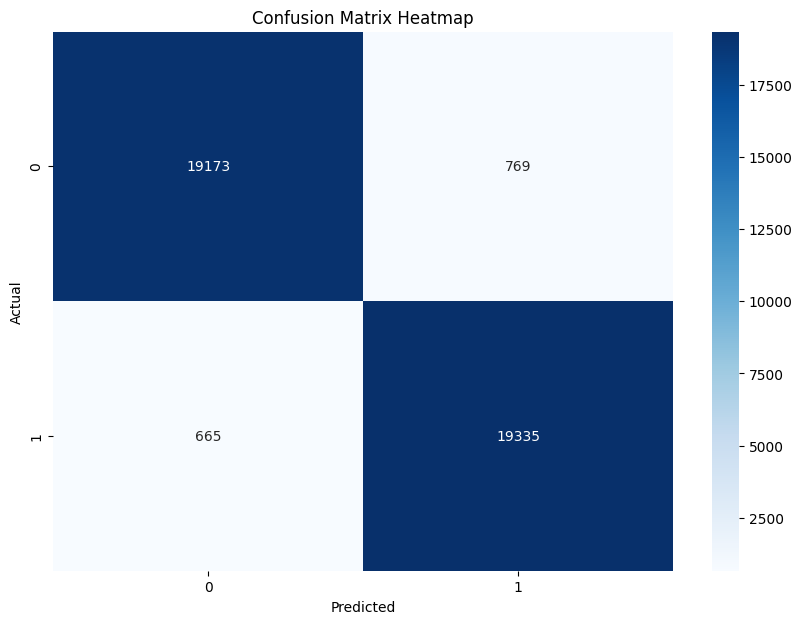

In [64]:
# Plot confusion matrix heatmap

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Saving Stacking Classifier Model

In [65]:
from joblib import Parallel, delayed 
import joblib 

In [66]:
joblib.dump(SC, 'D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\Dis-SBERT-mainFinal.pkl')  

['D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\Dis-SBERT-mainFinal.pkl']

# Loading Classifier Model

In [73]:
Stacking_Classifier_url=joblib.load('D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\SC-SBERT-mainFinal.pkl')

C:\Users\kanis\AppData\Local\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\kanis\AppData\Local\miniconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StackingClassifier from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [74]:
Stacking_Classifier_url.score(X_test,y_test)

0.9885333733914176

In [75]:
# Step 2: Make predictions on the test set
y_pred = Stacking_Classifier_url.predict(X_test)

# Step 3: Generate the classification report
report = classification_report(y_test, y_pred)

In [76]:
print("\nPerformance Metrics : ")
print("----------------------\n")

print("Stacking Classifier Accuracy   :",accuracy_score(y_test, y_pred))
print("Stacking Classifier Recall     :",recall_score(y_test, y_pred))
print("Stacking Classifier Precision  :",precision_score(y_test, y_pred))

print("\nClasification Report :")
print("-----------------------\n")

print(report)


Performance Metrics : 
----------------------

Stacking Classifier Accuracy   : 0.9885333733914176
Stacking Classifier Recall     : 0.98955
Stacking Classifier Precision  : 0.9875748502994012

Clasification Report :
-----------------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19942
           1       0.99      0.99      0.99     20000

    accuracy                           0.99     39942
   macro avg       0.99      0.99      0.99     39942
weighted avg       0.99      0.99      0.99     39942



In [159]:
fpr,tpr, thres=roc_curve(y_test, y_pred)

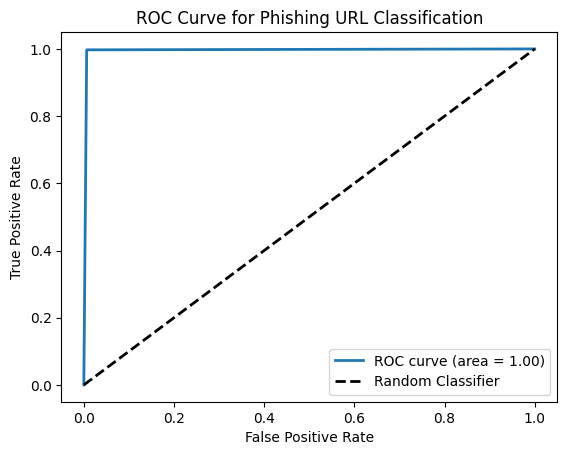

In [160]:
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier',lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [162]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

False Positive Rate: 0.0064


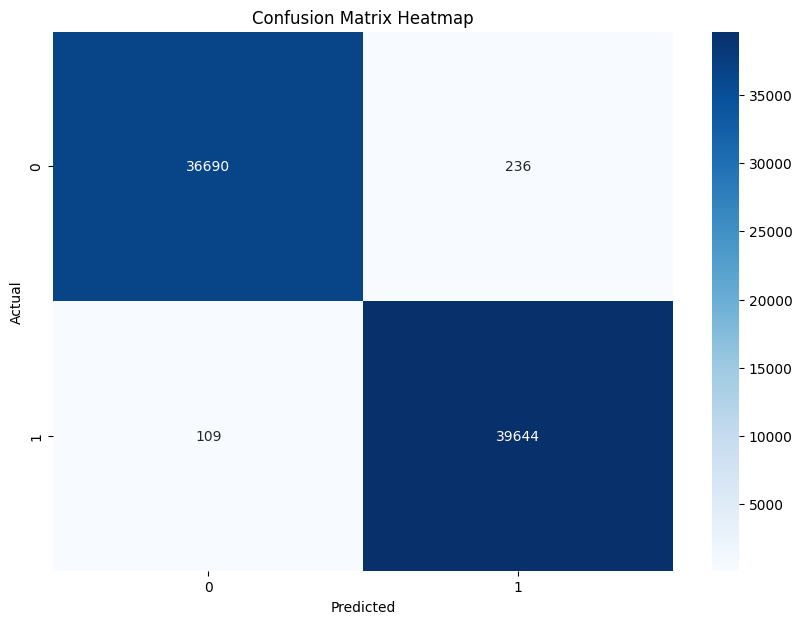

In [163]:
# Plot confusion matrix heatmap

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Short URL Handler

In [360]:
test='https://www.youtube.com/watch?v=M72Wu2rZE7Y&t=2043s'

In [361]:
test_features=extract_URL_features(test)
test_encoder=[s_bert_model.encode(test)]
test_features = pd.json_normalize(test_features)

In [362]:
test_features

,url_length,domain_length,path_length,num_subdomains,subdomain_length,path_depth,has_file_extension,equal_count,redirects,query_param_count,dot_char_count,hyphen_char_count,tld_domain_length,space_char_count,www_count,http_count,suspicious_path_keywords
0,51,15,6,1,3,1,0,2,1,1,2,0,3,0,1,1,0


In [363]:
test_url=pd.concat([test_features])

In [364]:
test_url['embeddings']=test_encoder

In [365]:
test_url.embeddings

0    [-0.054456674, 0.06418925, 0.087920085, 0.0451...
Name: embeddings, dtype: object

In [366]:
# Select numeric features excluding 'type'
features = test_url.drop(columns=['embeddings'])

# Normalize numeric features if necessary
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert embeddings to a 2D array
embeddings_array = np.stack(test_url['embeddings'].values)

# Concatenate features and embeddings
TEST = np.hstack((features_scaled, embeddings_array))

In [368]:
res=lr.predict(TEST)

In [369]:
print(res)

[0]


# BERT 

In [69]:
df= pd.read_csv("D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\BERT_v7.csv")

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199709 entries, 0 to 199708
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     199709 non-null  object
 1   type    199709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [71]:
# df=df.drop(columns=['embeddings'])

In [72]:
bert_all_embeddings = np.load('D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\BERT_v7_embeddings.npy')

In [73]:
features_reshaped = bert_all_embeddings.reshape((199709, -1))

In [74]:
df['url_length'] = df['url'].apply(len)

In [75]:
df = df[df['url_length'] <= 512].drop(columns=['url_length'])

In [70]:
df = df.drop_duplicates(subset=['url'])

In [71]:
df['URL'] = df['url'].str.strip("'")

In [88]:
df = df[~df['url'].str.contains('bitly|tinyURL', case=False, na=False)]

In [89]:
df = df.dropna(how='all')

In [77]:
type_counts = df['type'].value_counts()
type_counts

type
1    99998
0    99711
Name: count, dtype: int64

In [78]:
df.tail()

,url,type
199704,en.wikipedia.org/wiki/USS_Capricornus_(AKA-57),1
199705,muscleinjuries.com/fs56qjqt,0
199706,webmail.mhcable.com/secure/www.paypal.com/webs...,0
199707,publicrecords.com/people-search-records/meliss...,1
199708,freeserials.ws/sn/64850.html,0


In [79]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['url']

In [80]:
l_encoder = LabelEncoder()

encoded_data = l_encoder.fit_transform(df['type'])

df['type'] = encoded_data

In [81]:
import urllib.parse
from urllib.parse import unquote
import re
import math


def extract_URL_features(url):

  try:

    features = {}

    url=unquote(url) # convert encoding to text in URL

    parsed_url = urllib.parse.urlparse(url)

    if(("//") not in url):

      url=url.strip("//")

      url_path="".join([part for part in url.split("/")[1:]])

      features['url_length']=len(url)

      features['domain_length']=len(url.split("/")[0])

      features['path_length'] = (sum(len(part) for part in url.split("/")[1:]))

      domain_parts=url.split("/")[0].split('.')

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0

      features['path_depth'] = len(url.split("/"))

      features['has_file_extension'] = 1 if re.search(r'\.\w+$', url_path) else 0

      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      # # Digit to letter ratio
      # digit_count = sum(1 for char in url_path if char.isdigit())
      # letter_count = sum(1 for char in url_path if char.isalpha())
      # features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0


      suspicious_keywords = ["login", "update", "verify", "secure", "account","password","reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in url_path.lower() for word in suspicious_keywords)


    else:

      domain_parts = parsed_url.netloc.split('.')
      
      features['url_length']=len(url)
      # print("url : ",url)

      features['domain_length']=len(parsed_url.netloc)
      # print("domain : ",parsed_url.netloc)

      features['path_length'] = len(parsed_url.path)
      # print("path : ",parsed_url.path)

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0
      # print("domain :",domain_parts)

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0
      features['path_depth'] = parsed_url.path.count('/')
      features['has_file_extension'] = 1 if re.search(r'\.\w+$', parsed_url.path) else 0
      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      # digit_count = sum(1 for char in parsed_url.path if char.isdigit())
      # letter_count = sum(1 for char in parsed_url.path if char.isalpha())
      # features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0

      suspicious_keywords = ["login", "update", "verify", "secure", "account","password", "reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in parsed_url.path.lower() for word in suspicious_keywords)

  except Exception as e:
    print("Exception in URL :",url)
    return None  # Return None or a default value for failed cases

  return features
    
extract_URL_features("apple-checker.org/")


{'url_length': 17,
 'domain_length': 17,
 'path_length': 0,
 'num_subdomains': 0,
 'subdomain_length': 0,
 'path_depth': 1,
 'has_file_extension': 0,
 'equal_count': 0,
 'redirects': 0,
 'query_param_count': 0,
 'dot_char_count': 1,
 'hyphen_char_count': 1,
 'tld_domain_length': 3,
 'space_char_count': 0,
 'www_count': 0,
 'http_count': 0,
 'suspicious_path_keywords': 0}

In [82]:
fs=df['url'].map(extract_URL_features)

In [83]:
fs=fs.to_list()

In [84]:
url_features_frame = pd.json_normalize(fs)

In [85]:
df = df.reset_index(drop=True)
url_features_frame = url_features_frame.reset_index(drop=True)
df = pd.concat([df, url_features_frame], axis=1)
print(df.shape)

(199709, 19)


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199709 entries, 0 to 199708
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   url                       199709 non-null  object
 1   type                      199709 non-null  int64 
 2   url_length                199709 non-null  int64 
 3   domain_length             199709 non-null  int64 
 4   path_length               199709 non-null  int64 
 5   num_subdomains            199709 non-null  int64 
 6   subdomain_length          199709 non-null  int64 
 7   path_depth                199709 non-null  int64 
 8   has_file_extension        199709 non-null  int64 
 9   equal_count               199709 non-null  int64 
 10  redirects                 199709 non-null  int64 
 11  query_param_count         199709 non-null  int64 
 12  dot_char_count            199709 non-null  int64 
 13  hyphen_char_count         199709 non-null  int64 
 14  tld_

In [87]:
from sklearn.preprocessing import StandardScaler

# Select numeric features excluding 'type'
features = df.drop(columns=['type','url'])

# Normalize numeric features if necessary
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert embeddings to a 2D array
embeddings_array = np.stack(features_reshaped)

# Concatenate features and embeddings
X = np.hstack((features_scaled, embeddings_array))
y = df['type'].values

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

In [97]:
clf_lgb=LGBMClassifier(learning_rate= 0.09092019196120222,
num_leaves = 200,
max_depth = 23,
min_child_samples = 47,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)

In [73]:
clf_lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 79998, number of negative: 79769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 9.004053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784762
[LightGBM] [Info] Number of data points in the train set: 159767, number of used features: 3090
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500717 -> initscore=0.002867
[LightGBM] [Info] Start training from score 0.002867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

LGBMClassifier(colsample_bytree=0.8200479625575507,
               learning_rate=0.09092019196120223, max_depth=23,
               min_child_samples=47, n_estimators=1000, num_leaves=200,
               subsample=0.9808438292511631)

In [74]:
clf_lgb_predict = clf_lgb.predict(X_test)
print("LightGBM Classifier Accuracy:",accuracy_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Recall:",recall_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Precision:",precision_score(y_test, clf_lgb_predict))

LightGBM Classifier Accuracy: 0.9688298032146613
LightGBM Classifier Recall: 0.9713
LightGBM Classifier Precision: 0.9666119321291735


In [89]:
estimators = []

estimators.append(('XGB', XGBClassifier(objective="binary:logistic",random_state=13,n_estimators=1000,
    max_depth=15,
    gamma=6,
    reg_alpha=80,
    min_child_weight=5,
    colsample_bytree=0.5)))
estimators.append(('CatBoost',  CatBoostClassifier(iterations=2000)))
estimators.append(('LightGBM', LGBMClassifier(learning_rate= 0.05092019196120222,
num_leaves = 200,
max_depth = 22,
min_child_samples = 50,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)))

In [90]:
LR_clf = LogisticRegression()

In [91]:
SC = StackingClassifier(estimators=estimators,final_estimator=LR_clf)

In [92]:
SC.fit(X_train, y_train)

Learning rate set to 0.047619
0:	learn: 0.6523016	total: 1.51s	remaining: 50m 14s
1:	learn: 0.6171126	total: 2.96s	remaining: 49m 14s
2:	learn: 0.5867461	total: 4.49s	remaining: 49m 49s
3:	learn: 0.5603009	total: 5.99s	remaining: 49m 47s
4:	learn: 0.5364346	total: 7.43s	remaining: 49m 24s
5:	learn: 0.5163173	total: 8.86s	remaining: 49m 4s
6:	learn: 0.4980838	total: 10.3s	remaining: 48m 44s
7:	learn: 0.4814617	total: 11.7s	remaining: 48m 30s
8:	learn: 0.4645868	total: 13.1s	remaining: 48m 8s
9:	learn: 0.4499578	total: 13.8s	remaining: 45m 49s
10:	learn: 0.4376021	total: 14.7s	remaining: 44m 9s
11:	learn: 0.4261523	total: 15.5s	remaining: 42m 44s
12:	learn: 0.4160948	total: 16.3s	remaining: 41m 25s
13:	learn: 0.4064883	total: 17.1s	remaining: 40m 27s
14:	learn: 0.3969502	total: 17.9s	remaining: 39m 28s
15:	learn: 0.3886588	total: 18.7s	remaining: 38m 41s
16:	learn: 0.3804932	total: 19.5s	remaining: 37m 53s
17:	learn: 0.3732495	total: 20.3s	remaining: 37m 11s
18:	learn: 0.3667606	total: 2

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=6,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate...
                                              num_parallel_tree=None,
                                              random_state=13, ...)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x0000027E01F2FED0>),
                               ('LightGBM',
                                LGBMClassifier(colsample_bytree=0.8200479625575507,
                                               learning_rate=0.05092019196120222,
                                               max_depth=22,
                                               min_child_samples=50,
                                               n_estimators=1000,
                                               num_leaves=200,
                                               subsample=0.9808438292511631))],
                   final_estimator=LogisticRegression())

In [93]:
SC_pred = SC.predict(X_test)
print("Stacking Classifier Accuracy:",metrics.accuracy_score(y_test, SC_pred))
print("Stacking Classifier Recall:",metrics.recall_score(y_test, SC_pred))
print("Stacking  Classifier Precision:",metrics.precision_score(y_test, SC_pred))
report = classification_report(y_test, SC_pred)

print(report)

Stacking Classifier Accuracy: 0.9619448199889841
Stacking Classifier Recall: 0.964
Stacking  Classifier Precision: 0.9601593625498008
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19942
           1       0.96      0.96      0.96     20000

    accuracy                           0.96     39942
   macro avg       0.96      0.96      0.96     39942
weighted avg       0.96      0.96      0.96     39942



In [94]:
# Make predictions
y_train_lgb_pred = SC.predict(X_train)
y_test_lgb_pred = SC.predict(X_test)

# Calculate accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_lgb_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_lgb_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9967515194001264
Test Accuracy: 0.9619448199889841


In [95]:
fpr,tpr, thres=roc_curve(y_test, SC_pred)

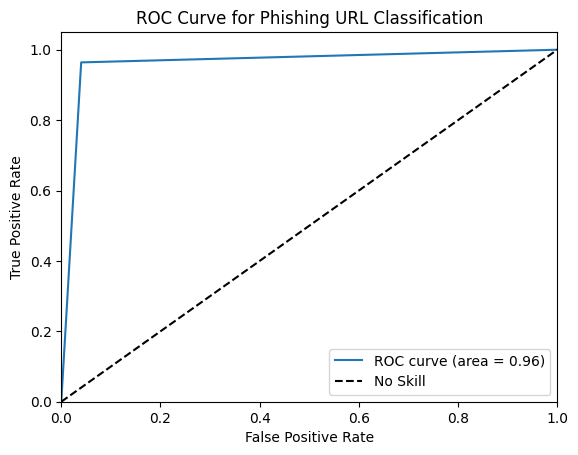

In [96]:
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')
plt.legend()
plt.show()

In [99]:
joblib.dump(SC, 'D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\Dis-BERT-Main.pkl')  

['D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\Dis-BERT-Main.pkl']

# Roberta model

In [100]:
df= pd.read_csv("D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\BERT_v7.csv")

In [101]:
bert_all_embeddings = np.load('D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\BERT_Roberta_embeddings.npy')

In [102]:
features_reshaped = bert_all_embeddings.reshape((199709, -1))

In [103]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['url']

In [104]:
l_encoder = LabelEncoder()

encoded_data = l_encoder.fit_transform(df['type'])

df['type'] = encoded_data

In [105]:
import urllib.parse
from urllib.parse import unquote
import re
import math


def extract_URL_features(url):

  try:

    features = {}

    url=unquote(url) # convert encoding to text in URL

    parsed_url = urllib.parse.urlparse(url)

    if(("//") not in url):

      url=url.strip("//")

      url_path="".join([part for part in url.split("/")[1:]])

      features['url_length']=len(url)

      features['domain_length']=len(url.split("/")[0])

      features['path_length'] = (sum(len(part) for part in url.split("/")[1:]))

      domain_parts=url.split("/")[0].split('.')

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0

      features['path_depth'] = len(url.split("/"))

      features['has_file_extension'] = 1 if re.search(r'\.\w+$', url_path) else 0

      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      # # Digit to letter ratio
      # digit_count = sum(1 for char in url_path if char.isdigit())
      # letter_count = sum(1 for char in url_path if char.isalpha())
      # features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0


      suspicious_keywords = ["login", "update", "verify", "secure", "account","password","reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in url_path.lower() for word in suspicious_keywords)


    else:

      domain_parts = parsed_url.netloc.split('.')
      
      features['url_length']=len(url)
      # print("url : ",url)

      features['domain_length']=len(parsed_url.netloc)
      # print("domain : ",parsed_url.netloc)

      features['path_length'] = len(parsed_url.path)
      # print("path : ",parsed_url.path)

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0
      # print("domain :",domain_parts)

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0
      features['path_depth'] = parsed_url.path.count('/')
      features['has_file_extension'] = 1 if re.search(r'\.\w+$', parsed_url.path) else 0
      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      # digit_count = sum(1 for char in parsed_url.path if char.isdigit())
      # letter_count = sum(1 for char in parsed_url.path if char.isalpha())
      # features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0

      suspicious_keywords = ["login", "update", "verify", "secure", "account","password", "reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in parsed_url.path.lower() for word in suspicious_keywords)

  except Exception as e:
    print("Exception in URL :",url)
    return None  # Return None or a default value for failed cases

  return features
    
extract_URL_features("apple-checker.org/")


{'url_length': 17,
 'domain_length': 17,
 'path_length': 0,
 'num_subdomains': 0,
 'subdomain_length': 0,
 'path_depth': 1,
 'has_file_extension': 0,
 'equal_count': 0,
 'redirects': 0,
 'query_param_count': 0,
 'dot_char_count': 1,
 'hyphen_char_count': 1,
 'tld_domain_length': 3,
 'space_char_count': 0,
 'www_count': 0,
 'http_count': 0,
 'suspicious_path_keywords': 0}

In [106]:
fs=df['url'].map(extract_URL_features)

In [107]:
fs=fs.to_list()

In [108]:
url_features_frame = pd.json_normalize(fs)

In [109]:
df = df.reset_index(drop=True)
url_features_frame = url_features_frame.reset_index(drop=True)
df = pd.concat([df, url_features_frame], axis=1)
print(df.shape)

(199709, 19)


In [110]:
from sklearn.preprocessing import StandardScaler

# Select numeric features excluding 'type'
features = df.drop(columns=['type','url'])

# Normalize numeric features if necessary
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert embeddings to a 2D array
embeddings_array = np.stack(features_reshaped)

# Concatenate features and embeddings
X = np.hstack((features_scaled, embeddings_array))
y = df['type'].values

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

In [110]:
clf_lgb=LGBMClassifier(learning_rate= 0.09092019196120222,
num_leaves = 200,
max_depth = 23,
min_child_samples = 47,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)

In [111]:
clf_lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 79998, number of negative: 79769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.955318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196982
[LightGBM] [Info] Number of data points in the train set: 159767, number of used features: 785
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500717 -> initscore=0.002867
[LightGBM] [Info] Start training from score 0.002867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

LGBMClassifier(colsample_bytree=0.8200479625575507,
               learning_rate=0.09092019196120223, max_depth=23,
               min_child_samples=47, n_estimators=1000, num_leaves=200,
               subsample=0.9808438292511631)

In [112]:
clf_lgb_predict = clf_lgb.predict(X_test)
print("LightGBM Classifier Accuracy:",accuracy_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Recall:",recall_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Precision:",precision_score(y_test, clf_lgb_predict))

LightGBM Classifier Accuracy: 0.9686295127935507
LightGBM Classifier Recall: 0.97285
LightGBM Classifier Precision: 0.9647939703475975


In [116]:
estimators = []

estimators.append(('XGB', XGBClassifier(objective="binary:logistic",random_state=13,n_estimators=1000,
    max_depth=15,
    gamma=6,
    reg_alpha=80,
    min_child_weight=5,
    colsample_bytree=0.5)))
estimators.append(('CatBoost',  CatBoostClassifier(iterations=2000)))
estimators.append(('LightGBM', LGBMClassifier(learning_rate= 0.05092019196120222,
num_leaves = 200,
max_depth = 22,
min_child_samples = 50,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)))

In [117]:
LR_clf = LogisticRegression()

In [118]:
SC = StackingClassifier(estimators=estimators,final_estimator=LR_clf)

In [119]:
SC.fit(X_train, y_train)

Learning rate set to 0.047619
0:	learn: 0.6517638	total: 241ms	remaining: 8m 1s
1:	learn: 0.6225310	total: 502ms	remaining: 8m 21s
2:	learn: 0.5926145	total: 724ms	remaining: 8m 2s
3:	learn: 0.5663527	total: 974ms	remaining: 8m 5s
4:	learn: 0.5444946	total: 1.23s	remaining: 8m 9s
5:	learn: 0.5252488	total: 1.48s	remaining: 8m 11s
6:	learn: 0.5072255	total: 1.73s	remaining: 8m 13s
7:	learn: 0.4865012	total: 1.97s	remaining: 8m 10s
8:	learn: 0.4717206	total: 2.23s	remaining: 8m 12s
9:	learn: 0.4591238	total: 2.47s	remaining: 8m 11s
10:	learn: 0.4468978	total: 2.77s	remaining: 8m 21s
11:	learn: 0.4336312	total: 3.09s	remaining: 8m 31s
12:	learn: 0.4227563	total: 3.42s	remaining: 8m 43s
13:	learn: 0.4112568	total: 3.72s	remaining: 8m 47s
14:	learn: 0.4022239	total: 4.03s	remaining: 8m 52s
15:	learn: 0.3939904	total: 4.3s	remaining: 8m 53s
16:	learn: 0.3859388	total: 4.57s	remaining: 8m 52s
17:	learn: 0.3794766	total: 4.85s	remaining: 8m 54s
18:	learn: 0.3715644	total: 5.15s	remaining: 8m 5

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=6,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate...
                                              num_parallel_tree=None,
                                              random_state=13, ...)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x0000027D9EAFB650>),
                               ('LightGBM',
                                LGBMClassifier(colsample_bytree=0.8200479625575507,
                                               learning_rate=0.05092019196120222,
                                               max_depth=22,
                                               min_child_samples=50,
                                               n_estimators=1000,
                                               num_leaves=200,
                                               subsample=0.9808438292511631))],
                   final_estimator=LogisticRegression())

In [120]:
SC_pred = SC.predict(X_test)
print("Stacking Classifier Accuracy:",accuracy_score(y_test, SC_pred))
print("Stacking Classifier Recall:",recall_score(y_test, SC_pred))
print("Stacking  Classifier Precision:",precision_score(y_test, SC_pred))
report = classification_report(y_test, SC_pred)

print(report)

Stacking Classifier Accuracy: 0.9648991037003656
Stacking Classifier Recall: 0.96505
Stacking  Classifier Precision: 0.9648570285942811
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19942
           1       0.96      0.97      0.96     20000

    accuracy                           0.96     39942
   macro avg       0.96      0.96      0.96     39942
weighted avg       0.96      0.96      0.96     39942



In [121]:
# Make predictions
y_train_lgb_pred = SC.predict(X_train)
y_test_lgb_pred = SC.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_lgb_pred)
test_accuracy = accuracy_score(y_test, y_test_lgb_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9955122146626024
Test Accuracy: 0.9648991037003656


In [122]:
fpr,tpr, thres=roc_curve(y_test, SC_pred)

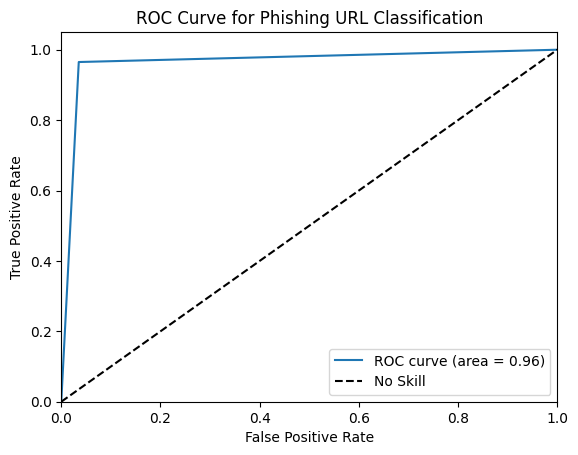

In [123]:
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')
plt.legend()
plt.show()

In [124]:
joblib.dump(SC, 'D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\Dis-RoBERTa-Main.pkl')  

['D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\Dis-RoBERTa-Main.pkl']

# Tiny-BERT

In [125]:
df= pd.read_csv("D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\BERT_v7.csv")

In [126]:
bert_all_embeddings = np.load('D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\v1_tinyBert_embeddings.npy')

In [127]:
features_reshaped = bert_all_embeddings.reshape((199709, -1))

In [128]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['url']

In [129]:
l_encoder = LabelEncoder()

encoded_data = l_encoder.fit_transform(df['type'])

df['type'] = encoded_data

In [130]:
import urllib.parse
from urllib.parse import unquote
import re
import math


def extract_URL_features(url):

  try:

    features = {}

    url=unquote(url) # convert encoding to text in URL

    parsed_url = urllib.parse.urlparse(url)

    if(("//") not in url):

      url=url.strip("//")

      url_path="".join([part for part in url.split("/")[1:]])

      features['url_length']=len(url)

      features['domain_length']=len(url.split("/")[0])

      features['path_length'] = (sum(len(part) for part in url.split("/")[1:]))

      domain_parts=url.split("/")[0].split('.')

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0

      features['path_depth'] = len(url.split("/"))

      features['has_file_extension'] = 1 if re.search(r'\.\w+$', url_path) else 0

      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      # # Digit to letter ratio
      # digit_count = sum(1 for char in url_path if char.isdigit())
      # letter_count = sum(1 for char in url_path if char.isalpha())
      # features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0


      suspicious_keywords = ["login", "update", "verify", "secure", "account","password","reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in url_path.lower() for word in suspicious_keywords)


    else:

      domain_parts = parsed_url.netloc.split('.')
      
      features['url_length']=len(url)
      # print("url : ",url)

      features['domain_length']=len(parsed_url.netloc)
      # print("domain : ",parsed_url.netloc)

      features['path_length'] = len(parsed_url.path)
      # print("path : ",parsed_url.path)

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0
      # print("domain :",domain_parts)

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0
      features['path_depth'] = parsed_url.path.count('/')
      features['has_file_extension'] = 1 if re.search(r'\.\w+$', parsed_url.path) else 0
      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      # digit_count = sum(1 for char in parsed_url.path if char.isdigit())
      # letter_count = sum(1 for char in parsed_url.path if char.isalpha())
      # features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0

      suspicious_keywords = ["login", "update", "verify", "secure", "account","password", "reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in parsed_url.path.lower() for word in suspicious_keywords)

  except Exception as e:
    print("Exception in URL :",url)
    return None  # Return None or a default value for failed cases

  return features
    
extract_URL_features("apple-checker.org/")


{'url_length': 17,
 'domain_length': 17,
 'path_length': 0,
 'num_subdomains': 0,
 'subdomain_length': 0,
 'path_depth': 1,
 'has_file_extension': 0,
 'equal_count': 0,
 'redirects': 0,
 'query_param_count': 0,
 'dot_char_count': 1,
 'hyphen_char_count': 1,
 'tld_domain_length': 3,
 'space_char_count': 0,
 'www_count': 0,
 'http_count': 0,
 'suspicious_path_keywords': 0}

In [131]:
fs=df['url'].map(extract_URL_features)

In [132]:
fs=fs.to_list()

In [133]:
url_features_frame = pd.json_normalize(fs)

In [134]:
df = df.reset_index(drop=True)
url_features_frame = url_features_frame.reset_index(drop=True)
df = pd.concat([df, url_features_frame], axis=1)
print(df.shape)

(199709, 19)


In [135]:
from sklearn.preprocessing import StandardScaler

# Select numeric features excluding 'type'
features = df.drop(columns=['type','url'])

# Normalize numeric features if necessary
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert embeddings to a 2D array
embeddings_array = np.stack(features_reshaped)

# Concatenate features and embeddings
X = np.hstack((features_scaled, embeddings_array))
y = df['type'].values

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

In [137]:
estimators = []

estimators.append(('XGB', XGBClassifier(objective="binary:logistic",random_state=13,n_estimators=1000,
    max_depth=15,
    gamma=6,
    reg_alpha=80,
    min_child_weight=5,
    colsample_bytree=0.5)))
estimators.append(('CatBoost',  CatBoostClassifier(iterations=2000)))
estimators.append(('LightGBM', LGBMClassifier(learning_rate= 0.05092019196120222,
num_leaves = 200,
max_depth = 22,
min_child_samples = 50,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)))

In [138]:
SC = StackingClassifier(estimators=estimators,final_estimator=LR_clf)

In [139]:
SC.fit(X_train, y_train)

Learning rate set to 0.047619
0:	learn: 0.6504653	total: 277ms	remaining: 9m 13s
1:	learn: 0.6184941	total: 541ms	remaining: 9m
2:	learn: 0.5903728	total: 805ms	remaining: 8m 55s
3:	learn: 0.5602897	total: 1.04s	remaining: 8m 39s
4:	learn: 0.5393232	total: 1.3s	remaining: 8m 37s
5:	learn: 0.5188146	total: 1.53s	remaining: 8m 28s
6:	learn: 0.5009390	total: 1.79s	remaining: 8m 29s
7:	learn: 0.4849321	total: 2.03s	remaining: 8m 25s
8:	learn: 0.4694930	total: 2.26s	remaining: 8m 20s
9:	learn: 0.4533067	total: 2.51s	remaining: 8m 19s
10:	learn: 0.4395884	total: 2.74s	remaining: 8m 16s
11:	learn: 0.4269676	total: 2.99s	remaining: 8m 16s
12:	learn: 0.4167145	total: 3.24s	remaining: 8m 14s
13:	learn: 0.4068252	total: 3.5s	remaining: 8m 16s
14:	learn: 0.3980786	total: 3.76s	remaining: 8m 17s
15:	learn: 0.3903670	total: 4.03s	remaining: 8m 19s
16:	learn: 0.3832714	total: 4.28s	remaining: 8m 19s
17:	learn: 0.3760272	total: 4.54s	remaining: 8m 19s
18:	learn: 0.3678160	total: 4.75s	remaining: 8m 15

StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=6,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate...
                                              num_parallel_tree=None,
                                              random_state=13, ...)),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x0000027FAB7DEC10>),
                               ('LightGBM',
                                LGBMClassifier(colsample_bytree=0.8200479625575507,
                                               learning_rate=0.05092019196120222,
                                               max_depth=22,
                                               min_child_samples=50,
                                               n_estimators=1000,
                                               num_leaves=200,
                                               subsample=0.9808438292511631))],
                   final_estimator=LogisticRegression())

In [140]:
SC_pred = SC.predict(X_test)
print("Stacking Classifier Accuracy:",accuracy_score(y_test, SC_pred))
print("Stacking Classifier Recall:",recall_score(y_test, SC_pred))
print("Stacking  Classifier Precision:",precision_score(y_test, SC_pred))
report = classification_report(y_test, SC_pred)

print(report)

Stacking Classifier Accuracy: 0.9624705823443994
Stacking Classifier Recall: 0.96115
Stacking  Classifier Precision: 0.9638004512409125
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     19942
           1       0.96      0.96      0.96     20000

    accuracy                           0.96     39942
   macro avg       0.96      0.96      0.96     39942
weighted avg       0.96      0.96      0.96     39942



In [141]:
# Make predictions
y_train_lgb_pred = SC.predict(X_train)
y_test_lgb_pred = SC.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_lgb_pred)
test_accuracy = accuracy_score(y_test, y_test_lgb_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9978781600706028
Test Accuracy: 0.9624705823443994


In [142]:
fpr,tpr, thres=roc_curve(y_test, SC_pred)

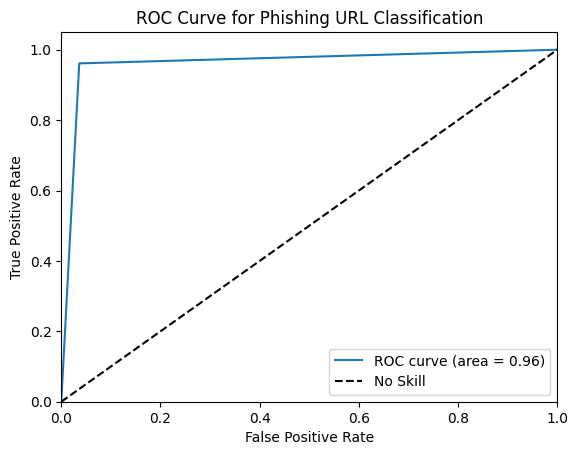

In [143]:
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')
plt.legend()
plt.show()

In [144]:
joblib.dump(SC, 'D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\Dis-TinyBERT-Main.pkl')  

['D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\BERT_vs_SBERT\\Dis-TinyBERT-Main.pkl']